### Image Augmentation using inbuilt keras class ImageDataGenerator, and cutout of one patch of 8 pixels with val=average of the dataset. Later used Cyclic LR which gave 1.5% improvement, from 88.5 to 90%
With heavier augmentation of imgaug, there was no improvement in 50 epochs.

In [0]:
import numpy as np
import keras
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, GlobalAveragePooling2D
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as k
from keras.utils import np_utils

from keras.datasets import mnist, cifar10
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/"
!ls

batch_size = 128

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


### Load pre-shuffled CIFAR data into train and test sets


In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print(Y_train.shape)


(50000, 10)


#### https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py

In [0]:
def get_img_mean(img_dataset):
  #print(img_dataset.shape)
  avg = np.mean(img_dataset)
  return avg

def my_cutout(length, val):
  def patch(input_img):
    h = input_img.shape[0]
    w = input_img.shape[1] 
    
    mask = np.ones((h, w), np.float32)
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - length // 2, 0, h) # specific area val clipped to 0, h, 0-h
    y2 = np.clip(y + length // 2, 0, h)
    x1 = np.clip(x - length // 2, 0, w)
    x2 = np.clip(x + length // 2, 0, w)
    input_img[y1: y2, x1: x2, :] = val
    # print("Patch coordinates", y1, y2, x1, x2)
    # print("Patch dim", y2-y1, x2-x1)
    return input_img
  return patch

#### Image augmentation and cutout of one patch of 8 pixels with val=average of the dataset

In [0]:
c = get_img_mean(X_train)
cutout = my_cutout(8, c)
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   zoom_range = 0.2,
                                   brightness_range=[0.8, 1.2],
                                   width_shift_range=0.15, 
                                   height_shift_range=0.15, 
                                   rotation_range=20, 
                                   horizontal_flip=True,
                                   preprocessing_function=cutout)
test_datagen = ImageDataGenerator(rescale= 1./255)

train_gen = train_datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True, seed=42)
test_gen = test_datagen.flow(X_test, Y_test, batch_size=batch_size, shuffle=True, seed=42)

train_steps = len(train_gen)
test_steps = len(test_gen)
print("Steps :",train_steps, test_steps)

Steps : 391 79


#### Displaying train images

(128, 32, 32, 3)


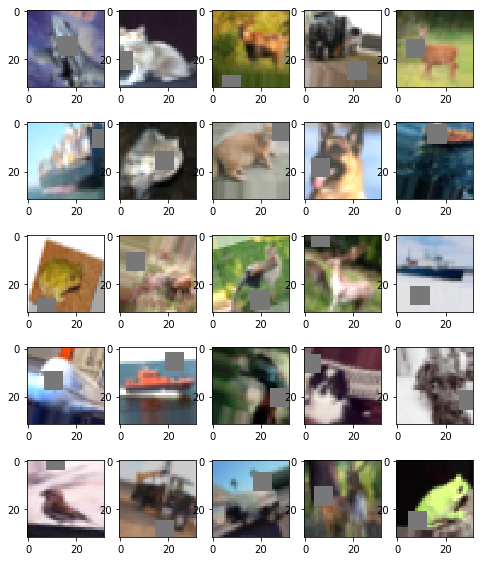

In [0]:
for i in range(15):
    x_batch, y_batch = next(train_gen)
print(x_batch.shape)

# Plot Generator images
fig = plt.figure(figsize=(8, 10))

for i in range(25):
    sub = fig.add_subplot(5, 5, i + 1)    
    sub.imshow(x_batch[i,:,:], interpolation='nearest')

#### Taking earlier model with cifar

In [0]:
def build_model():
  model = Sequential()
  
  model.add(Conv2D(48, 3, padding='same', input_shape=(32, 32, 3), activation='relu', use_bias=False)) #rf 3
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(96, 3, padding='same', activation='relu', use_bias=False)) 
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(64, 1, activation='relu', ))
  model.add(MaxPooling2D(pool_size=(2, 2))) #16, rf10  

  model.add(Conv2D(96, 3, padding='same', activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(192, 3, padding='same', activation='relu', use_bias=False)) #16, rf14
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(128, 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #8, rf28
  
  model.add(Conv2D(192, 3, padding='same', activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Conv2D(384, 3, padding='same', activation='relu', use_bias=False))#8, rf32
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
    
  model.add(Conv2D(200, 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2))) #4, rf64
   
  model.add(Conv2D(100, 1, activation='relu'))
  model.add(Conv2D(10, 4))
    
  model.add(GlobalAveragePooling2D())
  model.add(Activation('softmax'))
  return model

#### Best validation accuracy was **88.53% at epoch 46, when training acc was 86.35**%. Thus overfitting has been fixed with image aug and cutout.

In [0]:
model=build_model()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

file =  dir + "cifar_cutout.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model_info = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=50, 
                    validation_data=test_gen, validation_steps=test_steps, callbacks=[checkpoint])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1296      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        41472     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 96)        0        

In [0]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])  # default is 0.001

model.load_weights(dir + "cifar_cutout.46-0.8853.hdf5")
print("Loaded model from disk ")

model.evaluate_generator(generator=test_gen, steps=test_steps, verbose=1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Loaded model from disk 
79/79 [==============================] - 5s 66ms/step


[0.34890303726196287, 0.8853]

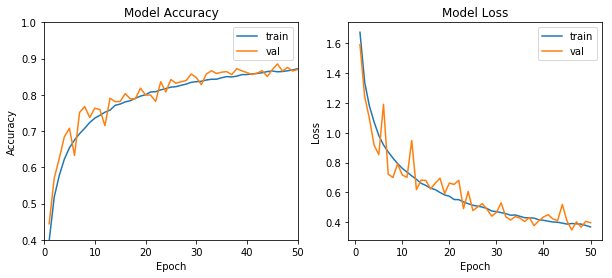

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    # Set axis properties [xmin, xmax, ymin, ymax]
    axs[0].axis([0,50,0.4,1])
    
    # Plot training & validation accuracy values
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Plot training & validation loss values
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(model_info)

#### Training with cyclic LR
Best validation accuracy was **90.10% at epoch 45, when training acc was 92.89%**. 1.5% improvement.

In [0]:
!git clone "https://github.com/bckenstler/CLR.git"

Cloning into 'CLR'...
remote: Enumerating objects: 244, done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (244/244), 1.37 MiB | 1.55 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [0]:
!ls CLR

clr_callback.py  clr_callback_tests.ipynb  images  LICENSE  README.md


In [0]:
from CLR.clr_callback import *

clr_model=build_model()
clr_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

file =  dir + "cifar_cutout_clr.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

clr = CyclicLR(5e-4, max_lr=5e-3, step_size=2000., mode='triangular2')
model_info = clr_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=50, 
                    validation_data=test_gen, validation_steps=test_steps, callbacks=[clr, checkpoint])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
391/391 [==============================] - 69s 176ms/step - loss: 1.6938 - acc: 0.3876 - val_loss: 2.5355 - val_acc: 0.3567

Epoch 00001: val_acc improved from -inf to 0.35670, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/cifar_cutout_clr.01-0.3567.hdf5
Epoch 2/50
391/391 [==============================] - 63s 162ms/step - loss: 1.3975 - acc: 0.4952 - val_loss: 1.5256 - val_acc: 0.5058

Epoch 00002: val_acc improved from 0.35670 to 0.50580, saving model to /content/gdrive/My Drive/Colab Notebooks/EVA/Cifar/Weights/cifar_cutout_clr.02-0.5058.hdf5
Epoch 3/50
391/391 [==============================] - 64s 163ms/step - loss: 1.2647 - acc: 0.5483 - val_loss: 1.5304 - val_acc: 0.4425

Epoch 00003: val_acc did not improve from 0.50580
Epoc

In [0]:
clr_model = build_model()
clr_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])  # default is 0.001

clr_model.load_weights(dir + "cifar_cutout_clr.50-0.9011.hdf5")
print("Loaded model from disk ")

clr_model.evaluate_generator(generator=test_gen, steps=test_steps, verbose=1)

Loaded model from disk 
79/79 [==============================] - 3s 35ms/step


[0.31157470302581786, 0.9011]

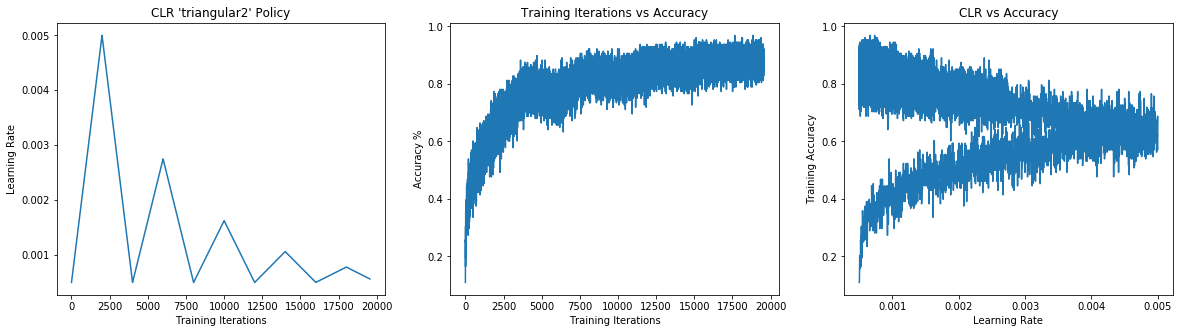

In [0]:
plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 3, 1)
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR 'triangular2' Policy")

plt.subplot(1, 3, 2)
plt.plot(clr.history['iterations'], clr.history['acc'])
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy %')
plt.title("Training Iterations vs Accuracy")

plt.subplot(1, 3, 3)
plt.plot(clr.history['lr'], clr.history['acc'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Accuracy')
plt.title("CLR vs Accuracy")

plt.show()

In [0]:
# Y_pred = clr_model.predict_generator(generator=test_gen, steps=test_steps, verbose=1)
# y_pred = np.argmax(Y_pred, axis=1)
print(y_pred[:5])
print(y_test.shape)

from sklearn.metrics import classification_report, confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix", confusion)
print(classification_report(y_test, y_pred))

# Precision for zero : 104/sum of column 0. col 0 - pred val zero, row 0 - actual value zero
# number of correctly predicted zero out of all predicted zero


[2 1 3 8 9]
(10000, 1)
Confusion matrix [[104 100 116 106  73  94 104  98 100 105]
 [101  88  94  80  94 104 131 105  97 106]
 [ 90 123  90  81 105  92 114 109  93 103]
 [118 111  96  83 106  79  97  96 104 110]
 [ 90 111  95  98  96  85 115 106 104 100]
 [115 128  87  88 104  86  96 120  69 107]
 [105 109 117  84  93  96 110  94 105  87]
 [ 92 105  98  90 100  93 108 106 107 101]
 [ 93 103 101 105 127  83 115  98  99  76]
 [ 93  93 103 104  97  87 107 110  94 112]]
              precision    recall  f1-score   support

           0       0.10      0.10      0.10      1000
           1       0.08      0.09      0.08      1000
           2       0.09      0.09      0.09      1000
           3       0.09      0.08      0.09      1000
           4       0.10      0.10      0.10      1000
           5       0.10      0.09      0.09      1000
           6       0.10      0.11      0.10      1000
           7       0.10      0.11      0.10      1000
           8       0.10      0.10      0.1